In [149]:
from tsi_toolkit import *
import tsi_toolkit as tsi
import numpy as np
import matplotlib.pyplot as plt
from pylag import *
import pylag
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


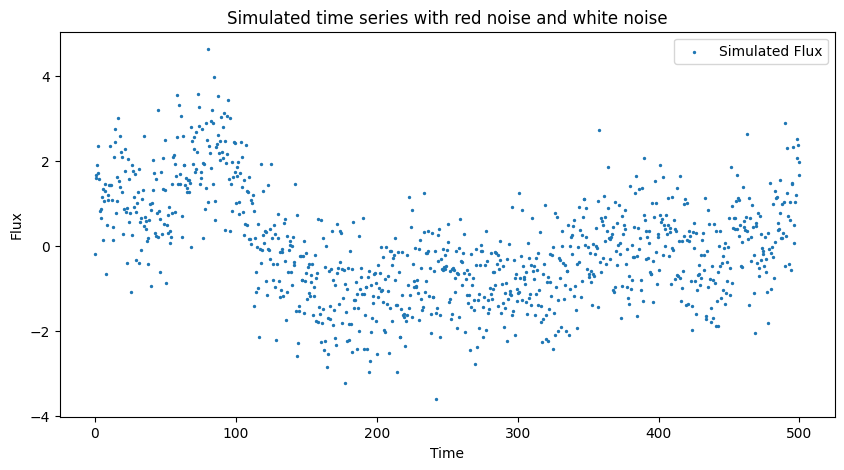

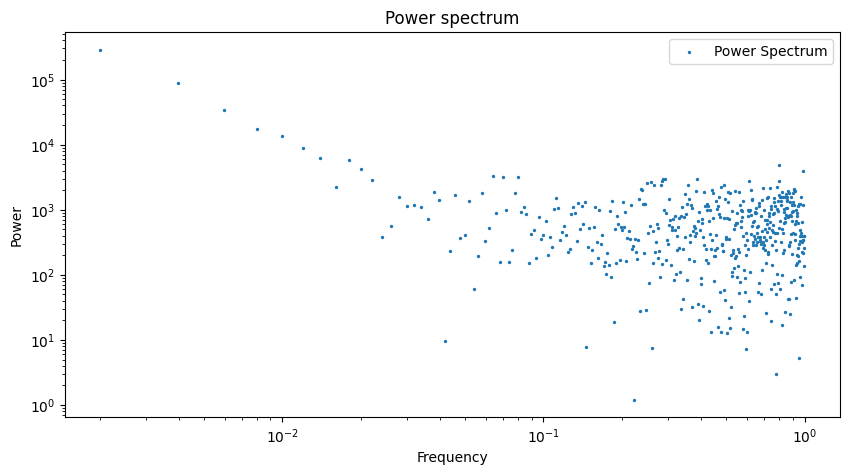

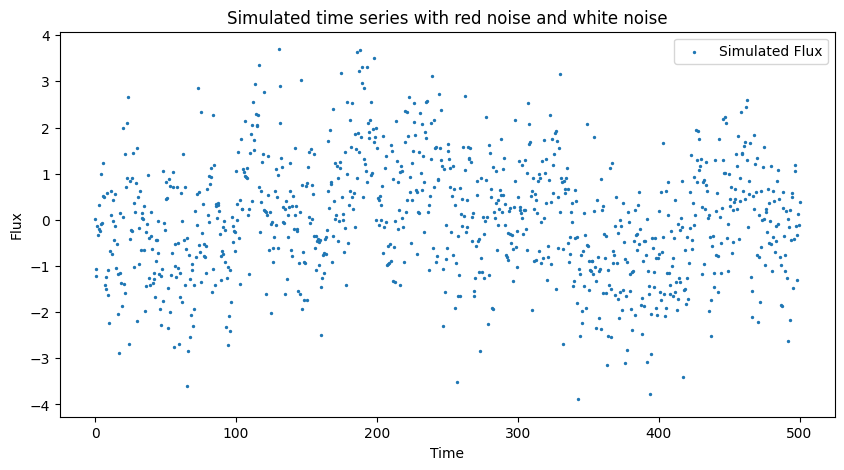

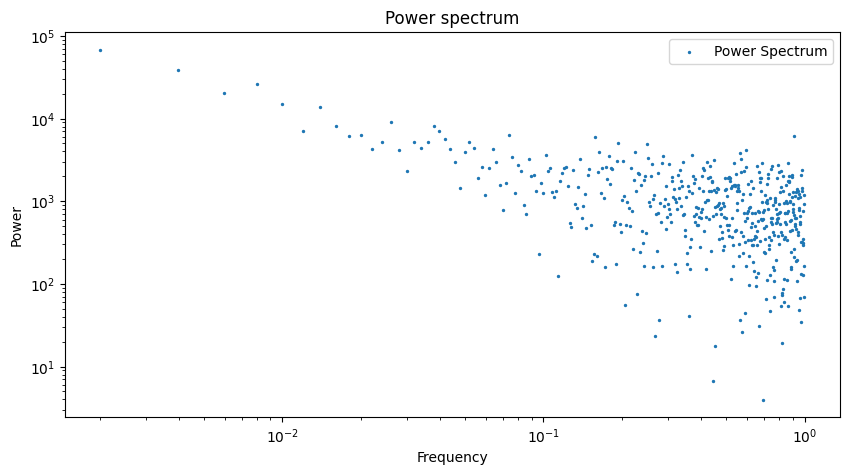

In [181]:
def simulate_time_series(
    n_points,  # Total duration of the time series (in arbitrary units, e.g., seconds or days)
    sampling_interval,  # Sampling interval for the time series
    alpha=2.0,  # Slope of the red noise PSD (alpha = 1 corresponds to 1/f noise)
    random_seed=None  # Optional seed for reproducibility
):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Define time array
    time = np.linspace(0, n_points*sampling_interval, n_points)
    dt = time[1] - time[0]

    # Generate frequencies for the Fourier transform
    freqs = np.fft.rfftfreq(n_points, d=dt)
    
    # Define the red noise PSD: P(f) ∝ 1 / f^alpha
    psd = 1 / (freqs + 1e-5) ** alpha  # Avoid division by zero
    
    # Generate random Fourier coefficients with the given PSD
    random_phases = np.exp(2j * np.pi * np.random.rand(len(freqs)))
    amplitudes = np.sqrt(psd)
    fourier_coeffs = amplitudes * random_phases
    
    # Perform inverse FFT to get the time series
    red_noise = np.fft.irfft(fourier_coeffs, n=n_points)
    
    # Normalize red noise to have a standard deviation of 1
    red_noise = (red_noise - np.mean(red_noise)) / np.std(red_noise)
    
    # Compute the mean flux of the red noise component
    mean_flux = np.mean(np.abs(red_noise))  # Use absolute to represent realistic flux
    
    # Resample white noise scaled by a fraction of the mean flux
    white_noise_level = mean_flux
    white_noise = white_noise_level * np.random.randn(n_points)
    
    # Combine red noise and white noise
    time_series = red_noise + white_noise

    # FFT of the combined time series
    fft = np.fft.rfft(time_series)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft) ** 2

    freq_mask = (freqs >= 1e-8) & (freqs <= 1/(2 * dt))
    freqs = freqs[freq_mask]
    power_spectrum = power_spectrum[freq_mask]
    fft = fft[freq_mask]
    
    return time, time_series, freqs, fft, power_spectrum

# Example usage
n_points = 1000 
sampling_interval = 0.5
time, time_series, freqs, fft, power_spectrum = simulate_time_series(
    n_points=n_points, 
    sampling_interval=sampling_interval, 
    alpha=2, 
    random_seed=42
)

time2, time_series2, freqs2, fft2, power_spectrum2 = simulate_time_series(
    n_points=n_points,
    sampling_interval=sampling_interval, 
    alpha=1, 
    random_seed=43
)
# Plot the resulting time series
plt.figure(figsize=(10, 5))
plt.scatter(time, time_series, s=2, label='Simulated Flux')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Simulated time series with red noise and white noise')
plt.legend()
plt.show()

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.scatter(freqs, power_spectrum, s=2, label='Power Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power spectrum')
plt.legend()
plt.show()

# Plot the resulting time series
plt.figure(figsize=(10, 5))
plt.scatter(time2, time_series2, s=2, label='Simulated Flux')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Simulated time series with red noise and white noise')
plt.legend()
plt.show()

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.scatter(freqs2, power_spectrum2, s=2, label='Power Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power spectrum')
plt.legend()
plt.show()


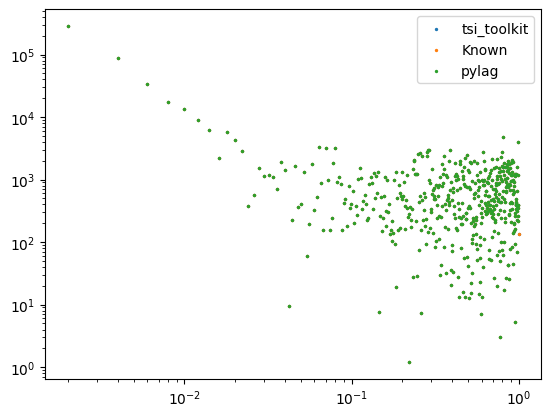

In [ ]:
# verify psd
power_spectrum_tsi = PowerSpectrum(times=time, values=time_series, norm=False)

# Check if power_spectrum_tsi.powers agrees with power_spectrum
assert np.allclose(power_spectrum_tsi.freqs, freqs), "The frequencies do not match!"
assert np.allclose(power_spectrum_tsi.powers, power_spectrum), "The power spectra do not match!"
lc_pylag = pylag.LightCurve(t=time, r=time_series)
power_spectrum_pylag = pylag.Periodogram(lc=lc_pylag, norm=False)

plt.scatter(power_spectrum_tsi.freqs, 
           power_spectrum_tsi.powers, label='tsi_toolkit',s=2)
plt.scatter(freqs[freqs >= 0], power_spectrum[freqs >= 0], label='Known',s=2)
plt.scatter(power_spectrum_pylag.freq, 
           power_spectrum_pylag.periodogram, label='pylag',s=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')

# verify cross spectrum
true_cross_spectrum = np.conj(fft) * fft2
cross_spectrum_tsi = tsi.CrossSpectrum(times1=time, values1=time_series, times2=time2, values2=time_series2, norm=False)

# Check if cross_spectrum_tsi.cs agrees with true_cross_spectrum
assert np.allclose(cross_spectrum_tsi.cs, true_cross_spectrum), "The cross spectra do not match!"

plt.scatter(cross_spectrum_tsi.freqs, 
            cross_spectrum_tsi.cs, label='tsi_toolkit',s=2)
plt.scatter(freqs[freqs >= 0], true_cross_spectrum[freqs >= 0], label='Known',s=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')

# verify lag frequency spectrum
true_lag_spectrum = np.angle(true_cross_spectrum) / (2 * np.pi * freqs)
lag_spectrum_tsi = tsi.LagFrequencySpectrum(
    times1=time, values1=time_series, times2=time2, values2=time_series2, subtract_coh_bias=False
    )

# Check if lag_spectrum_tsi.lags agrees with true_lag_spectrum
assert np.allclose(lag_spectrum_tsi.lags, true_lag_spectrum), "The lag spectra do not match!"

plt.scatter(lag_spectrum_tsi.freqs, lag_spectrum_tsi.lags, label='tsi_toolkit',s=2)
plt.scatter(freqs[freqs >= 0], true_lag_spectrum[freqs >= 0], label='Known',s=2)
plt.legend()
plt.xscale('log')

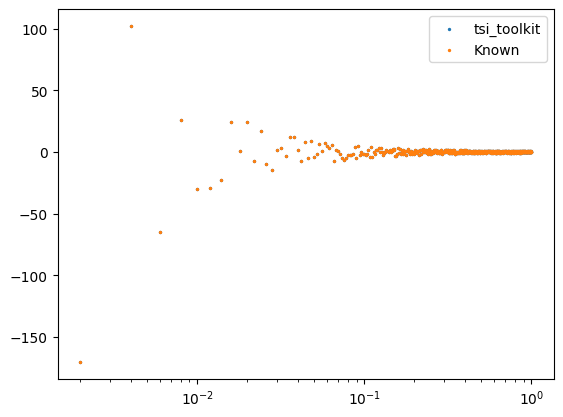